In [1]:
# パッケージのインポート
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ファイルの読み込み
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sample_submission = pd.read_csv('input/gender_submission.csv')

In [3]:
# 先頭5行確認
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# SexとEmbarkedのOne-Hotエンコーディング
train = pd.get_dummies(train, columns=['Sex', 'Embarked'])
test = pd.get_dummies(test, columns=['Sex', 'Embarked'])

# 不要な列の削除
train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

# trainの表示
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [5]:
# 説明変数と目的変数の切り分け
X_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']

In [6]:
# パッケージのインポート
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X_trainとY_trainをtrainとvalidに分割
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

# lab.Datasetでtrainとvalidを作っておく
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(valid_x, valid_y)

# パラメータを定義
lgbm_params = {'objective': 'binary'}

# lgb.trainで学習
evals_result = {}
gbm = lgb.train(params = lgbm_params,
                train_set = lgb_train,
                valid_sets= [lgb_train, lgb_eval],
                early_stopping_rounds=20,
                evals_result=evals_result,
                verbose_eval=10);

[LightGBM] [Info] Number of positive: 231, number of negative: 365
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387584 -> initscore=-0.457480
[LightGBM] [Info] Start training from score -0.457480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [7]:
# valid_xについて推論
oof = (gbm.predict(valid_x) > 0.5).astype(int)
print('score', round(accuracy_score(valid_y, oof)*100,2)) 

score 82.37


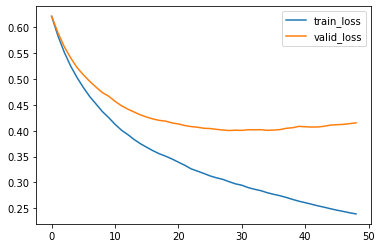

In [8]:
import matplotlib.pyplot as plt

plt.plot(evals_result['training']['binary_logloss'], label='train_loss')
plt.plot(evals_result['valid_1']['binary_logloss'], label='valid_loss')
plt.legend()

In [10]:
test_pred = (gbm.predict(test) > 0.5).astype(int)
sample_submission['Survived'] = test_pred
sample_submission.to_csv('train_test_split.csv', index=False)
#Score:0.76555